In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
import dask.dataframe as dd


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns




In [50]:
def extractor(df, threshold=0.9):
    """
    ************************************************************************
    EXPLANATIONS

    Filter features based on correlation threshold and visualize the correlation matrices.

    In practice a threshold of 0.9 is widespread but there exists more conservatve
    thresholds like 0.8 which is a more conservative approach. You may choose it
    depending on the context.

    ************************************************************************

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    threshold (float): The correlation threshold to filter features. Default is 0.9.

    Returns:
    selected_features (list): List of features with correlation below the threshold.
    excluded_features (list): List of features with correlation above the threshold.
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create lists for selected features ("normal correlations") and excluded features (perfectly/almost perfectly correlated)
    selected_features = []
    excluded_features = []

    # Run through the upper triangular matrix of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                excluded_features.append(colname)

    # fill lists of excluded and selected features
    excluded_features = list(set(excluded_features))
    selected_features = [feature for feature in corr_matrix.columns if feature not in excluded_features]

    # create correlation matrix of selected features
    selected_corr_matrix = corr_matrix.loc[selected_features, selected_features]

    # plot correlation matrix of selected features
    plt.figure(figsize=(12, 10))
    sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Selected Features')
    plt.show()

    # create correlation matrix of excluded features and plot it
    if excluded_features:
        remaining_corr_matrix = corr_matrix.loc[excluded_features, excluded_features]
        plt.figure(figsize=(20, 16))
        sns.heatmap(remaining_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Excluded Features')
        plt.show()
    else:
        print("No excluded features found.")

    # print lists of selected/excluded features
    print("Selected Features:", selected_features)
    print("Excluded Features:", excluded_features)


    # return lists of selected and excluded features
    return selected_features, excluded_features




(20018, 65)


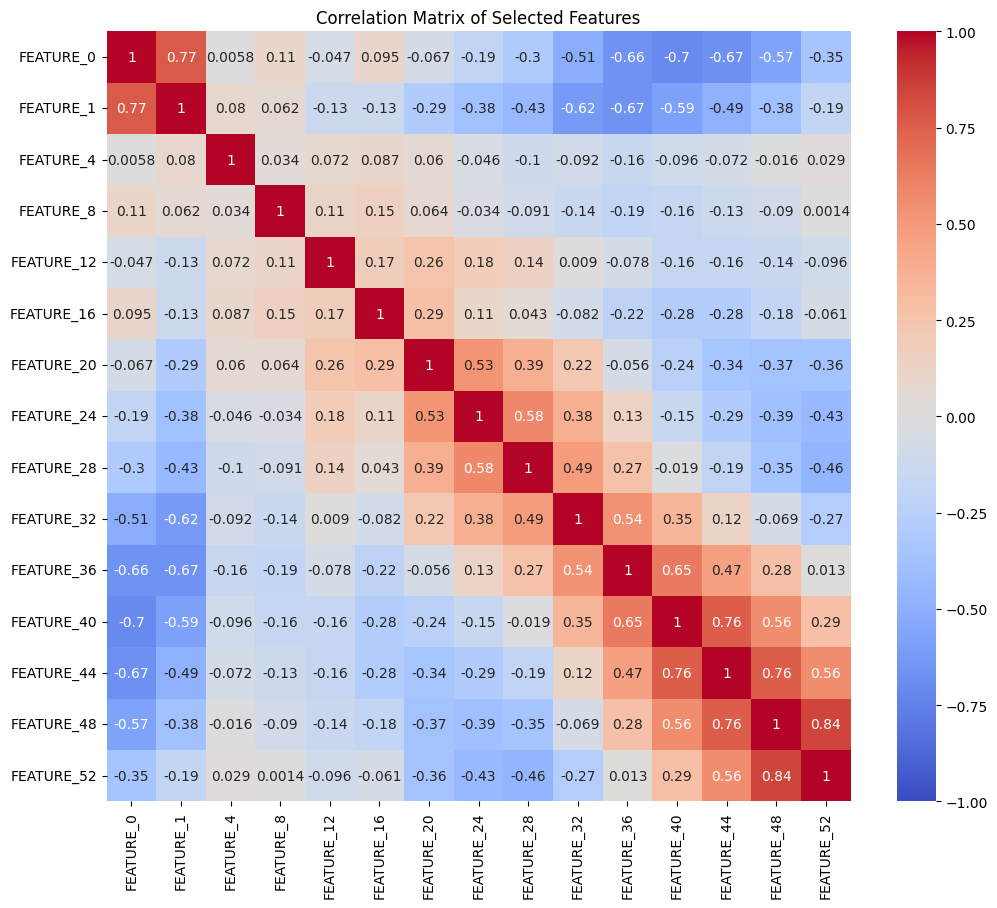

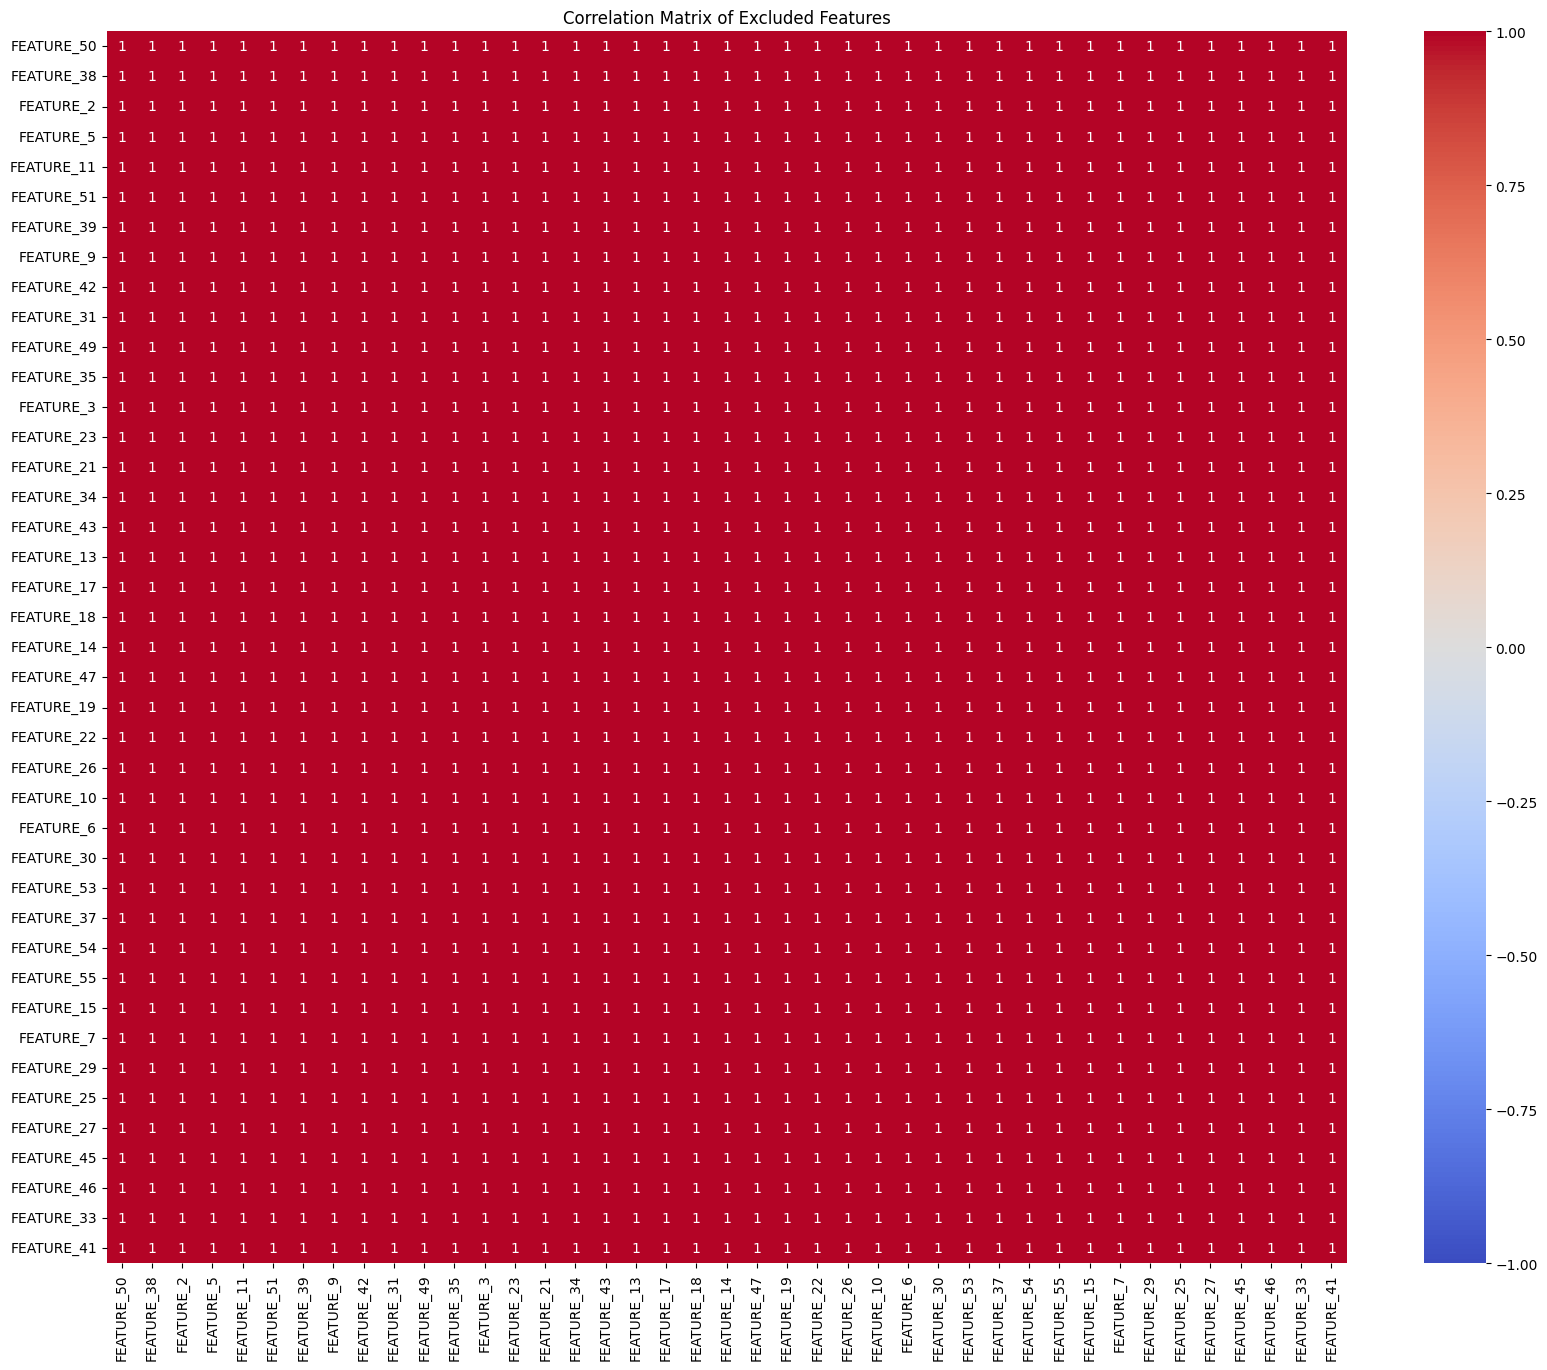

Selected Features: ['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']
Excluded Features: ['FEATURE_50', 'FEATURE_38', 'FEATURE_2', 'FEATURE_5', 'FEATURE_11', 'FEATURE_51', 'FEATURE_39', 'FEATURE_9', 'FEATURE_42', 'FEATURE_31', 'FEATURE_49', 'FEATURE_35', 'FEATURE_3', 'FEATURE_23', 'FEATURE_21', 'FEATURE_34', 'FEATURE_43', 'FEATURE_13', 'FEATURE_17', 'FEATURE_18', 'FEATURE_14', 'FEATURE_47', 'FEATURE_19', 'FEATURE_22', 'FEATURE_26', 'FEATURE_10', 'FEATURE_6', 'FEATURE_30', 'FEATURE_53', 'FEATURE_37', 'FEATURE_54', 'FEATURE_55', 'FEATURE_15', 'FEATURE_7', 'FEATURE_29', 'FEATURE_25', 'FEATURE_27', 'FEATURE_45', 'FEATURE_46', 'FEATURE_33', 'FEATURE_41']


(['FEATURE_0',
  'FEATURE_1',
  'FEATURE_4',
  'FEATURE_8',
  'FEATURE_12',
  'FEATURE_16',
  'FEATURE_20',
  'FEATURE_24',
  'FEATURE_28',
  'FEATURE_32',
  'FEATURE_36',
  'FEATURE_40',
  'FEATURE_44',
  'FEATURE_48',
  'FEATURE_52'],
 ['FEATURE_50',
  'FEATURE_38',
  'FEATURE_2',
  'FEATURE_5',
  'FEATURE_11',
  'FEATURE_51',
  'FEATURE_39',
  'FEATURE_9',
  'FEATURE_42',
  'FEATURE_31',
  'FEATURE_49',
  'FEATURE_35',
  'FEATURE_3',
  'FEATURE_23',
  'FEATURE_21',
  'FEATURE_34',
  'FEATURE_43',
  'FEATURE_13',
  'FEATURE_17',
  'FEATURE_18',
  'FEATURE_14',
  'FEATURE_47',
  'FEATURE_19',
  'FEATURE_22',
  'FEATURE_26',
  'FEATURE_10',
  'FEATURE_6',
  'FEATURE_30',
  'FEATURE_53',
  'FEATURE_37',
  'FEATURE_54',
  'FEATURE_55',
  'FEATURE_15',
  'FEATURE_7',
  'FEATURE_29',
  'FEATURE_25',
  'FEATURE_27',
  'FEATURE_45',
  'FEATURE_46',
  'FEATURE_33',
  'FEATURE_41'])

In [51]:
# Load the different datasets always activate only one and change title results accordingly

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2.csv')
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2.csv')


#keep track which threshold and version to save results correctly.
title_results = "TH14_V1"

print(data.shape)
columns_with_features = [col for col in data.columns if "FEATURE" in col]

extractor(data[columns_with_features])

In [52]:
# Define Data and Target for the training process

X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']
print(X.head)
print(X.shape)

<bound method NDFrame.head of        FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0       5.568156  -0.418359  -0.377895  -0.136180   -0.031328    1.278460   
1       4.561399  -0.404122  -0.365636  -0.229745   -0.205492    0.129325   
2       5.742884  -0.402946  -0.306957  -0.235184   -0.298659    0.855638   
3       6.743853  -0.320587  -0.316723  -0.247034    0.238286    0.012138   
4       3.873862  -0.457636  -0.442518  -0.455944   -0.212624    0.954134   
...          ...        ...        ...        ...         ...         ...   
20013   6.147456  -0.384802  -0.384817   0.003450    0.234367    0.876340   
20014   5.871015  -0.391352  -0.337181  -0.241910   -0.022697    0.268052   
20015   5.121576  -0.400474  -0.361893  -0.329308   -0.354427    0.633960   
20016   5.671898  -0.402877  -0.395588  -0.106220   -0.023199    0.120039   
20017   7.081014  -0.265816  -0.191067  -0.260138   -0.232467    0.388342   

       FEATURE_20  FEATURE_24  FEATURE_28  FE

In [53]:
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')
data4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2.csv')

#for better understanding I added the code from /Depression_Level_Classifier/feature_extraction.py instead of just calling it.


In [54]:
unique_values_1 = data1['Depression'].unique()
value_counts_1 = data1['Depression'].value_counts()
print("Value counts in the 'Depression' column for data1:")
print(value_counts_1)
print("\nUnique values in the 'Depression' column for data1:")
print(unique_values_1)

unique_values_2 = data2['Depression'].unique()
value_counts_2 = data2['Depression'].value_counts()
print("Value counts in the 'Depression' column for data2:")
print(value_counts_2)
print("\nUnique values in the 'Depression' column for data2:")
print(unique_values_2)

unique_values_3 = data3['Depression'].unique()
value_counts_3 = data3['Depression'].value_counts()
print("Value counts in the 'Depression' column for data3:")
print(value_counts_1)
print("\nUnique values in the 'Depression' column for data3:")
print(unique_values_1)

unique_values_4 = data4['Depression'].unique()
value_counts_4 = data4['Depression'].value_counts()
print("Value counts in the 'Depression' column for data4:")
print(value_counts_4)
print("\nUnique values in the 'Depression' column for data4:")
print(unique_values_4)

Value counts in the 'Depression' column for data1:
Depression
0    17396
1     2622
Name: count, dtype: int64

Unique values in the 'Depression' column for data1:
[0 1]
Value counts in the 'Depression' column for data2:
Depression
1    5380
0    2152
Name: count, dtype: int64

Unique values in the 'Depression' column for data2:
[0 1]
Value counts in the 'Depression' column for data3:
Depression
0    17396
1     2622
Name: count, dtype: int64

Unique values in the 'Depression' column for data3:
[0 1]
Value counts in the 'Depression' column for data4:
Depression
1    21520
0    16140
Name: count, dtype: int64

Unique values in the 'Depression' column for data4:
[0 1]


In [55]:
print("First row of data1:")
print(data1.head(1))

print("\nFirst row of data2:")
print(data2.head(1))

print("\nFirst row of data3:")
print(data3.head(1))

print("\nFirst row of data4:")
print(data4.head(1))

First row of data1:
         ID_1        ID_2                       group_id     SEX      AGE  \
0  H245741715  H679242502  Female_[49-53]_Healthy Weight  Female  [49-53]   

           HE_BMI           ID_COMBINED  d_PHQ  Depression  FEATURE_0  ...  \
0  Healthy Weight  H245741715H679242502    0.0           0   5.568156  ...   

   FEATURE_46  FEATURE_47  FEATURE_48  FEATURE_49  FEATURE_50  FEATURE_51  \
0   -0.418576    -0.41858    1.228448    -0.41858   -0.418577    -0.41858   

   FEATURE_52  FEATURE_53  FEATURE_54  FEATURE_55  
0     1.38564    -0.41858   -0.418578    -0.41858  

[1 rows x 65 columns]

First row of data2:
         ID_1        ID_2                       group_id     SEX      AGE  \
0  N246821615  B663188102  Female_[59-65]_Healthy Weight  Female  [59-65]   

           HE_BMI           ID_COMBINED  d_PHQ  Depression  FEATURE_0  ...  \
0  Healthy Weight  N246821615B663188102    0.0           0   6.410158  ...   

   FEATURE_46  FEATURE_47  FEATURE_48  FEATURE_49  FE

In [56]:
feature_columns = [col for col in data1 if 'FEATURE' in col]
X = data1[feature_columns]
print(X)
Y=data1['Depression']
print(Y)

#Training Test Split with 80/20 Ratio
train_X, test_X, train_Y, test_Y=train_test_split(X, Y, test_size=0.2, random_state=42)

       FEATURE_0  FEATURE_1  FEATURE_2  FEATURE_3  FEATURE_4  FEATURE_5  \
0       5.568156  -0.418359  -0.418544  -0.418580  -0.377895  -0.418593   
1       4.561399  -0.404122  -0.404325  -0.404338  -0.365636  -0.404325   
2       5.742884  -0.402946  -0.403065  -0.403091  -0.306957  -0.403078   
3       6.743853  -0.320587  -0.320697  -0.320747  -0.316723  -0.320750   
4       3.873862  -0.457636  -0.457802  -0.457852  -0.442518  -0.457843   
...          ...        ...        ...        ...        ...        ...   
20013   6.147456  -0.384802  -0.384933  -0.384982  -0.384817  -0.384982   
20014   5.871015  -0.391352  -0.391530  -0.391536  -0.337181  -0.391524   
20015   5.121576  -0.400474  -0.400746  -0.400754  -0.361893  -0.400737   
20016   5.671898  -0.402877  -0.403051  -0.403069  -0.395588  -0.403073   
20017   7.081014  -0.265816  -0.265929  -0.265954  -0.191067  -0.265964   

       FEATURE_6  FEATURE_7  FEATURE_8  FEATURE_9  ...  FEATURE_46  \
0      -0.418567  -0.418580  

data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDatase\t_100.csv')


First row of X:
   FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0   5.568156  -0.418359  -0.377895   -0.13618   -0.031328     1.27846   

   FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEATURE_36  FEATURE_40  \
0    0.331209    1.572426    1.212191    1.266114    1.825088    1.679312   

   FEATURE_44  FEATURE_48  FEATURE_52  
0    0.778244    1.228448     1.38564  
First value of y:
0    0
Name: Depression, dtype: int64
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Evaluation metrics:
Accuracy: 0.9863
Precision: 0.9979
Recall: 0.8971
F1-score: 0.9448
False Negative Rate: 0.1029
ROC-AUC: 0.9811
Confusion Matrix:
[[3478    1]
 [  54  471]]




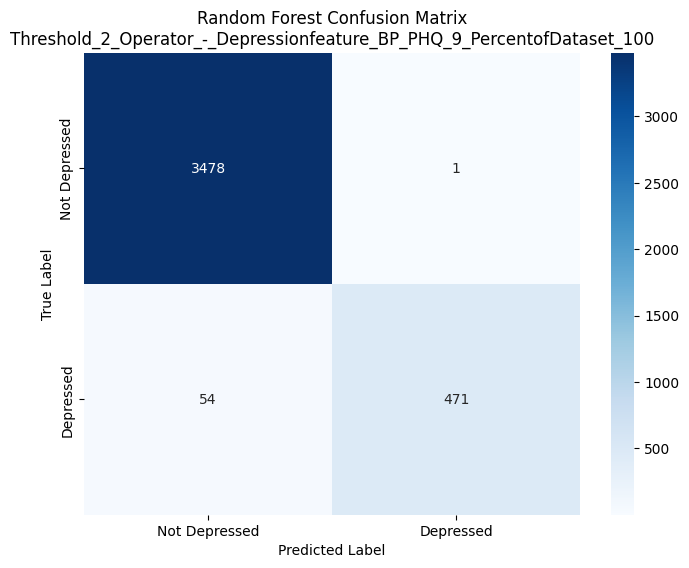

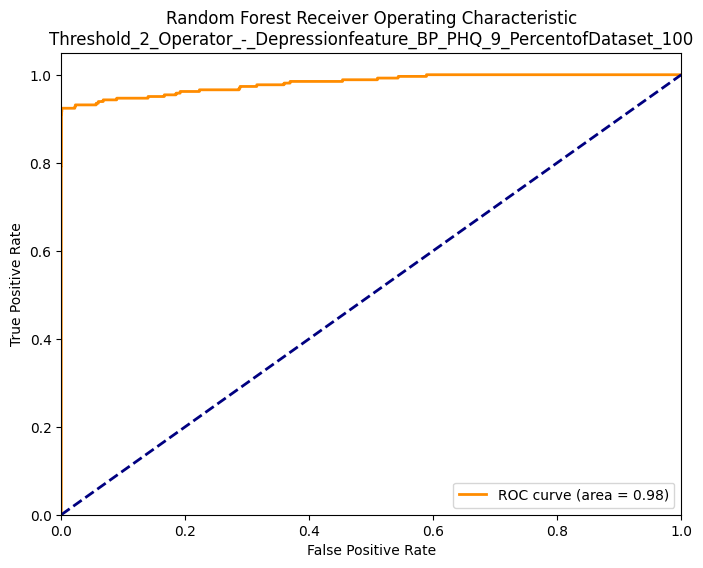

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Assuming you have loaded or defined your dataset data

def plot_confusion_matrix(cm, classes, title='Random Forest Confusion Matrix Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, title='Random Forest Receiver Operating Characteristic Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100', filename=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename)
    plt.show()

def evaluate_random_forest(X, y, output_prefix):
    # Step 1: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 2: Data preprocessing - Standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 3: Random Forest Classifier with Cross-Validation to find best parameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']  # 'auto' is deprecated
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Step 4: Evaluate model on test set
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_negative_rate = fn / (fn + tp)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

      # Display results
    print("\nEvaluation metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print("\n")


    # Save evaluation metrics
    with open(f"{output_prefix}_metrics.txt", "w") as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best ROC-AUC score on CV: {best_score:.4f}\n\n")
        f.write(f"Evaluation metrics:\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"False Negative Rate: {false_negative_rate:.4f}\n")
        f.write(f"ROC-AUC: {roc_auc:.4f}\n")
        f.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # Plot and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Not Depressed', 'Depressed'],
                          title=f'Random Forest Confusion Matrix\n{output_prefix}',
                          filename=f"{output_prefix}_confusion_matrix.png")

    # Plot and save ROC curve
    plot_roc_curve(fpr, tpr, roc_auc,
                   title=f'Random Forest Receiver Operating Characteristic\n{output_prefix}',
                   filename=f"{output_prefix}_roc_curve.png")

# Assuming you have loaded or defined your dataset data
data = data1  # Change this to your dataset variable name

# Select the features and target variable
X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']

# Print first row of X and first value of y to verify data
print("First row of X:")
print(X.head(1))
print("First value of y:")
print(y.head(1))

# Define output prefix for files
output_prefix = 'Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100'

# Evaluate the Random Forest model on the dataset
evaluate_random_forest(X, y, output_prefix)



data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2.csv')

First row of X:
   FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0   6.410158  -0.338817  -0.149501   -0.13509   -0.163625    1.983966   

   FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEATURE_36  FEATURE_40  \
0    0.823751    0.628846    0.467817    0.109832    0.425263    0.467625   

   FEATURE_44  FEATURE_48  FEATURE_52  
0     0.62065    1.055011    1.695691  
First value of y:
0    0
Name: Depression, dtype: int64
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Evaluation metrics:
Accuracy: 0.9443
Precision: 0.9437
Recall: 0.9780
F1-score: 0.9605
False Negative Rate: 0.0220
ROC-AUC: 0.9894
Confusion Matrix:
[[ 401   61]
 [  23 1022]]




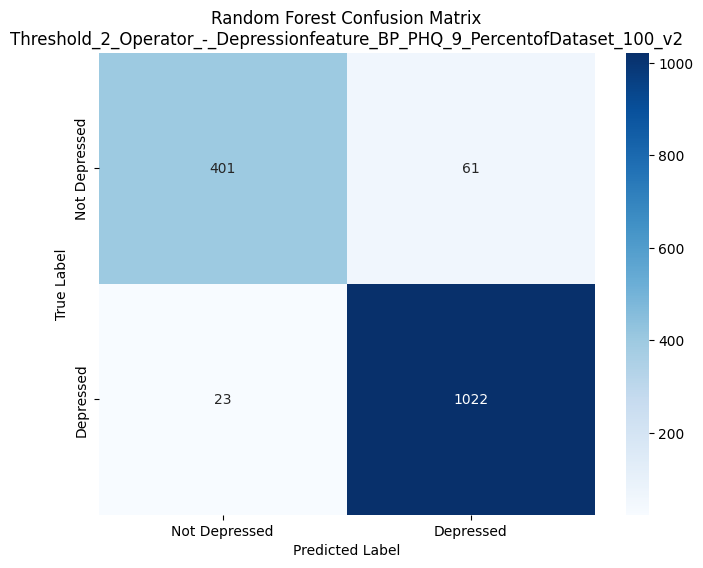

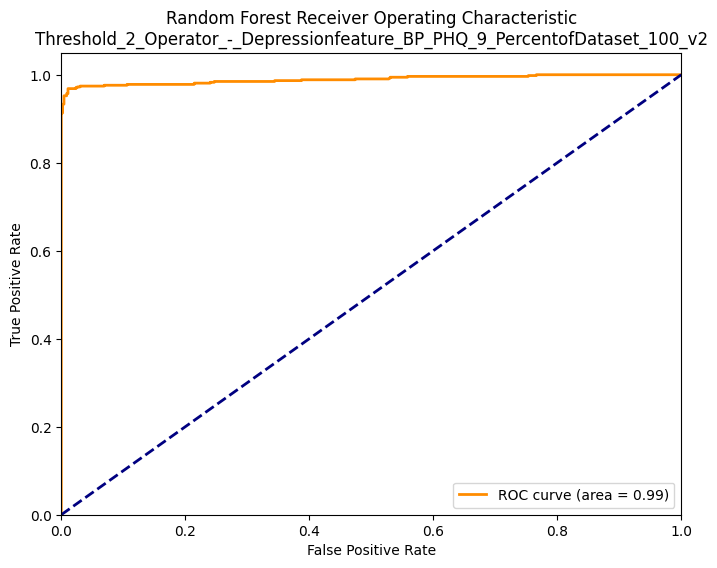

In [62]:
def plot_confusion_matrix(cm, classes, title='Random Forest Confusion Matrix Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, title='Random Forest Receiver Operating Characteristic Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2', filename=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename)
    plt.show()

def evaluate_random_forest(X, y, output_prefix):
    # Step 1: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 2: Data preprocessing - Standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 3: Random Forest Classifier with Cross-Validation to find best parameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']  # 'auto' is deprecated
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Step 4: Evaluate model on test set
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_negative_rate = fn / (fn + tp)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)


       # Display results
    print("\nEvaluation metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print("\n")

    # Save evaluation metrics
    with open(f"{output_prefix}_metrics.txt", "w") as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best ROC-AUC score on CV: {best_score:.4f}\n\n")
        f.write(f"Evaluation metrics:\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"False Negative Rate: {false_negative_rate:.4f}\n")
        f.write(f"ROC-AUC: {roc_auc:.4f}\n")
        f.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # Plot and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Not Depressed', 'Depressed'],
                          title=f'Random Forest Confusion Matrix\n{output_prefix}',
                          filename=f"{output_prefix}_confusion_matrix.png")

    # Plot and save ROC curve
    plot_roc_curve(fpr, tpr, roc_auc,
                   title=f'Random Forest Receiver Operating Characteristic\n{output_prefix}',
                   filename=f"{output_prefix}_roc_curve.png")

# Assuming you have loaded or defined your dataset data
data = data2  # Change this to your dataset variable name

# Select the features and target variable
X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']

# Print first row of X and first value of y to verify data
print("First row of X:")
print(X.head(1))
print("First value of y:")
print(y.head(1))

# Define output prefix for files
output_prefix = 'Threshold_2_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100_v2'

# Evaluate the Random Forest model on the dataset
evaluate_random_forest(X, y, output_prefix)


data3
data3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')

First row of X:
   FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0   6.322737  -0.342672  -0.321781  -0.311209   -0.062939    0.356013   

   FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEATURE_36  FEATURE_40  \
0    0.222068     0.17026    0.447239    0.442353    1.324866    1.226312   

   FEATURE_44  FEATURE_48  FEATURE_52  
0    1.578904     1.55103    1.456501  
First value of y:
0    0
Name: Depression, dtype: int64
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Evaluation metrics:
Accuracy: 0.9972
Precision: 0.9992
Recall: 0.9882
F1-score: 0.9937
False Negative Rate: 0.0118
ROC-AUC: 0.9983
Confusion Matrix:
[[8681    2]
 [  29 2434]]




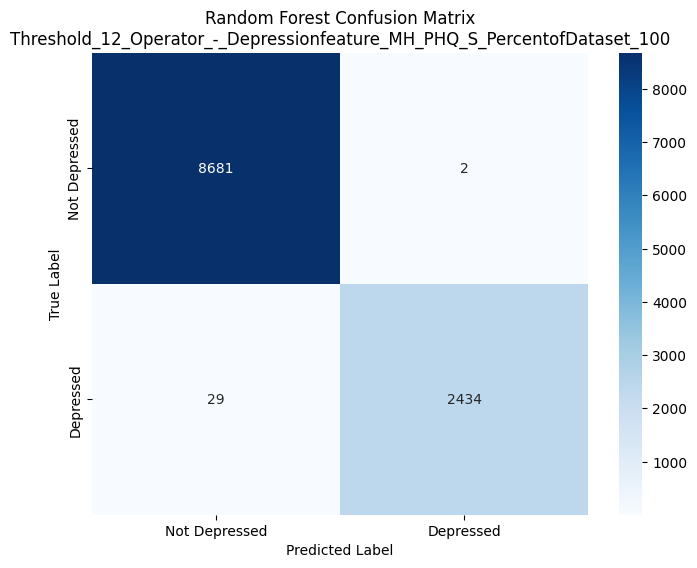

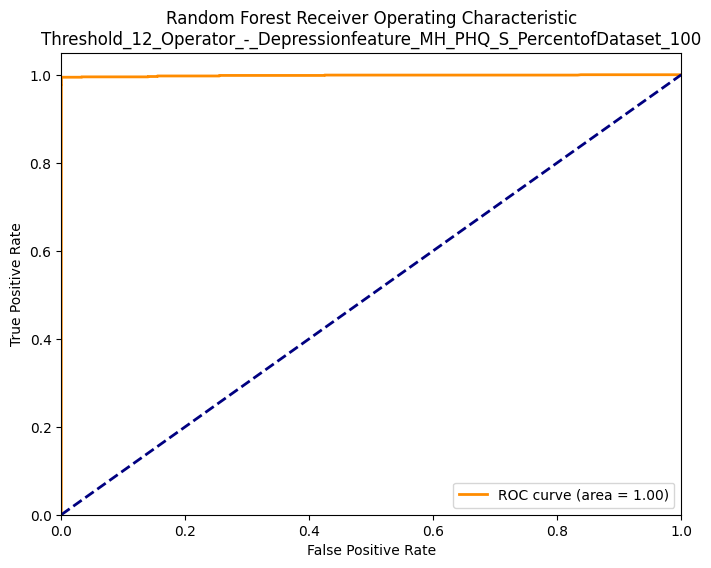

In [61]:
def plot_confusion_matrix(cm, classes, title='Random Forest Confusion Matrix Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, title='Random Forest Receiver Operating Characteristic Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100', filename=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename)
    plt.show()

def evaluate_random_forest(X, y, output_prefix):
    # Step 1: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 2: Data preprocessing - Standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 3: Random Forest Classifier with Cross-Validation to find best parameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']  # 'auto' is deprecated
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Step 4: Evaluate model on test set
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_negative_rate = fn / (fn + tp)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)


       # Display results
    print("\nEvaluation metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print("\n")

    # Save evaluation metrics
    with open(f"{output_prefix}_metrics.txt", "w") as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best ROC-AUC score on CV: {best_score:.4f}\n\n")
        f.write(f"Evaluation metrics:\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"False Negative Rate: {false_negative_rate:.4f}\n")
        f.write(f"ROC-AUC: {roc_auc:.4f}\n")
        f.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # Plot and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Not Depressed', 'Depressed'],
                          title=f'Random Forest Confusion Matrix\n{output_prefix}',
                          filename=f"{output_prefix}_confusion_matrix.png")

    # Plot and save ROC curve
    plot_roc_curve(fpr, tpr, roc_auc,
                   title=f'Random Forest Receiver Operating Characteristic\n{output_prefix}',
                   filename=f"{output_prefix}_roc_curve.png")

# Assuming you have loaded or defined your dataset data
data = data3  # Change this to your dataset variable name

# Select the features and target variable
X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']

# Print first row of X and first value of y to verify data
print("First row of X:")
print(X.head(1))
print("First value of y:")
print(y.head(1))

# Define output prefix for files
output_prefix = 'Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100'

# Evaluate the Random Forest model on the dataset
evaluate_random_forest(X, y, output_prefix)

data4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2.csv')

First row of X:
   FEATURE_0  FEATURE_1  FEATURE_4  FEATURE_8  FEATURE_12  FEATURE_16  \
0   5.425716  -0.400418  -0.396781  -0.274951   -0.235793    0.810335   

   FEATURE_20  FEATURE_24  FEATURE_28  FEATURE_32  FEATURE_36  FEATURE_40  \
0    0.473947    0.502981    0.458116    1.210409      1.0085    1.607107   

   FEATURE_44  FEATURE_48  FEATURE_52  
0    1.809462    2.097442    2.333726  
First value of y:
0    0
Name: Depression, dtype: int64
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Evaluation metrics:
Accuracy: 0.9989
Precision: 0.9986
Recall: 0.9995
F1-score: 0.9991
False Negative Rate: 0.0005
ROC-AUC: 1.0000
Confusion Matrix:
[[3271    6]
 [   2 4253]]




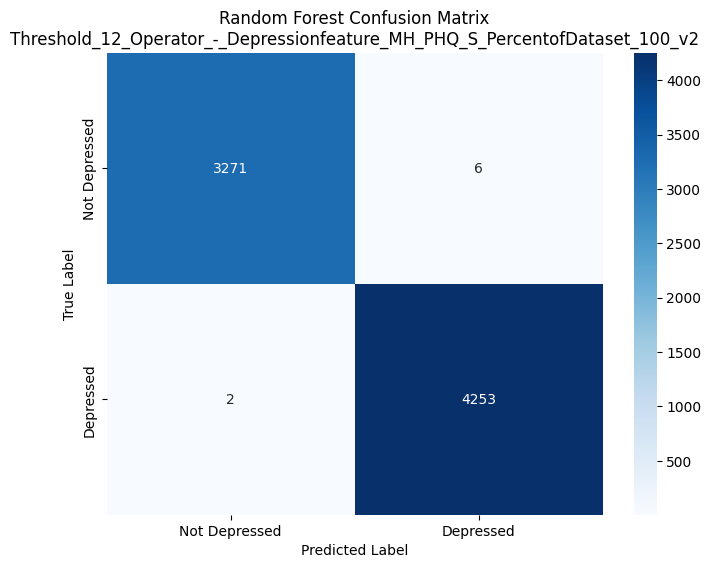

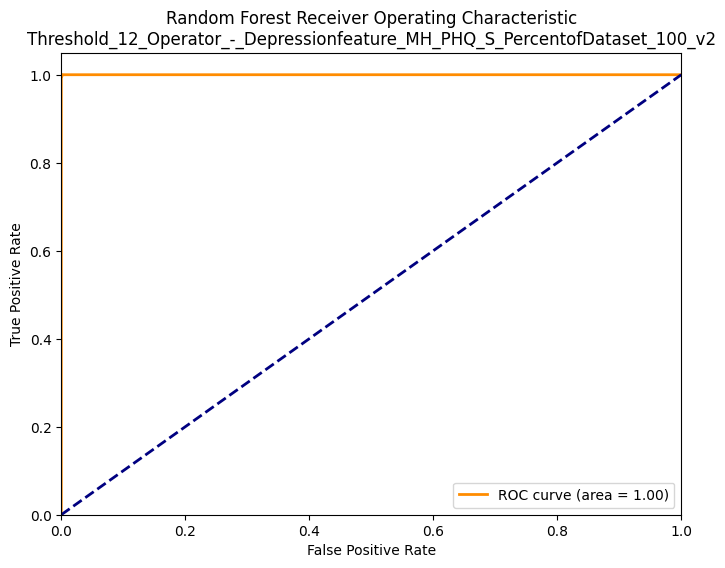

In [60]:
def plot_confusion_matrix(cm, classes, title='Random Forest Confusion Matrix Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2', cmap=plt.cm.Blues, filename=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, title='Random Forest Receiver Operating Characteristic Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2', filename=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename)
    plt.show()

def evaluate_random_forest(X, y, output_prefix):
    # Step 1: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 2: Data preprocessing - Standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Step 3: Random Forest Classifier with Cross-Validation to find best parameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']  # 'auto' is deprecated
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Step 4: Evaluate model on test set
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_negative_rate = fn / (fn + tp)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)


       # Display results
    print("\nEvaluation metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print("\n")

    # Save evaluation metrics
    with open(f"{output_prefix}_metrics.txt", "w") as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best ROC-AUC score on CV: {best_score:.4f}\n\n")
        f.write(f"Evaluation metrics:\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"False Negative Rate: {false_negative_rate:.4f}\n")
        f.write(f"ROC-AUC: {roc_auc:.4f}\n")
        f.write(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # Plot and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Not Depressed', 'Depressed'],
                          title=f'Random Forest Confusion Matrix\n{output_prefix}',
                          filename=f"{output_prefix}_confusion_matrix.png")

    # Plot and save ROC curve
    plot_roc_curve(fpr, tpr, roc_auc,
                   title=f'Random Forest Receiver Operating Characteristic\n{output_prefix}',
                   filename=f"{output_prefix}_roc_curve.png")

# Assuming you have loaded or defined your dataset data
data = data4 # Change this to your dataset variable name

# Select the features and target variable
X = data[['FEATURE_0', 'FEATURE_1', 'FEATURE_4', 'FEATURE_8', 'FEATURE_12', 'FEATURE_16', 'FEATURE_20', 'FEATURE_24', 'FEATURE_28', 'FEATURE_32', 'FEATURE_36', 'FEATURE_40', 'FEATURE_44', 'FEATURE_48', 'FEATURE_52']]
y = data['Depression']

# Print first row of X and first value of y to verify data
print("First row of X:")
print(X.head(1))
print("First value of y:")
print(y.head(1))

# Define output prefix for files
output_prefix = 'Threshold_12_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100_v2'

# Evaluate the Random Forest model on the dataset
evaluate_random_forest(X, y, output_prefix)
